**This notebook builds on an exercise in the [Computer Vision](https://www.kaggle.com/learn/computer-vision) course on kaggle.**




## Introduction #

In this notebook, I build a custom convnet with performance competitive to the pretrained VGG16 model from tensorflow hub.

#### dataset used was gotten from kaggle

In [1]:

# Imports
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells


# Load training and validation sets
ds_train_ = image_dataset_from_directory(
    '../input/car-or-truck/train',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)
ds_valid_ = image_dataset_from_directory(
    '../input/car-or-truck/valid',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
)

# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Found 5117 files belonging to 2 classes.
Found 5051 files belonging to 2 classes.


## Designing the Convnet #

 I experiment ways of improving the model either by adding more blocks or by adding convolutions to the blocks we have.


<figure>
<!-- <img src="./images/2-convmodel-2.png" width="250" alt="Diagram of a convolutional model."> -->
<img src="https://storage.googleapis.com/kaggle-media/learn/images/Vko6nCK.png" width="250" alt="Diagram of a convolutional model.">
</figure>

## 1) Define Model #


In [2]:
# base model
def base_convnet_model():
    model = keras.Sequential([
        layers.InputLayer(input_shape=[128, 128, 3]),
        
        layers.BatchNormalization(renorm=True),
        layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
        layers.MaxPool2D(),
        
        layers.BatchNormalization(renorm=True),
        layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
        layers.MaxPool2D(),
        
        layers.BatchNormalization(renorm=True),
        layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
        layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
        layers.MaxPool2D(),
        
    ])
    return model

# regular model
def create_regular_model():
    base_model = base_convnet_model()
    regular_model = keras.Sequential([
        base_model,
        layers.BatchNormalization(renorm=True),
        layers.Flatten(),
        layers.Dense(8, activation='relu'),
        layers.Dense(1, activation='sigmoid'),
    ])
    regular_model.build(input_shape=(None, 128, 128, 3))
    print(regular_model.summary())
    return regular_model



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 16, 16, 256)       962261    
                                                                 
 batch_normalization_3 (Batc  (None, 16, 16, 256)      1792      
 hNormalization)                                                 
                                                                 
 flatten (Flatten)           (None, 65536)             0         
                                                                 
 dense (Dense)               (None, 8)                 524296    
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1,488,358
Trainable params: 1,486,103
Non-trainable params: 2,255
________________________________________

In [4]:
regular_model = create_regular_model()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 16, 16, 256)       962261    
                                                                 
 batch_normalization_7 (Batc  (None, 16, 16, 256)      1792      
 hNormalization)                                                 
                                                                 
 flatten_1 (Flatten)         (None, 65536)             0         
                                                                 
 dense_2 (Dense)             (None, 8)                 524296    
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1,488,358
Trainable params: 1,486,103
Non-trainable params: 2,255
________________________________________

# 2) Compile #

To prepare for training, compile the model with an appropriate loss and accuracy metric for the "Car or Truck" dataset.

In [5]:
def compile_convnet_model(model,loss1 ='binary_crossentropy', accuracy = 'binary_accuracy'):  
    model.compile(
        optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
        loss=loss1,
        metrics=[accuracy]
    )
    return model


In [6]:
c_model = compile_convnet_model(regular_model)

Finally, let's test the performance of this new model. First run this cell to fit the model to the training set.

In [7]:
def train_convnet_model(model,ds_train,ds_valid):     
    history =  model.fit(
      ds_train,
      validation_data=ds_valid,
      epochs=50,)
    return history
    
history = train_convnet_model(c_model, ds_train, ds_valid)

Epoch 1/50
80/80 [==============================] - 40s 342ms/step - loss: 0.6736 - binary_accuracy: 0.5871 - val_loss: 0.6531 - val_binary_accuracy: 0.6302
Epoch 2/50
80/80 [==============================] - 7s 93ms/step - loss: 0.6470 - binary_accuracy: 0.6023 - val_loss: 0.6568 - val_binary_accuracy: 0.5751
Epoch 3/50
80/80 [==============================] - 7s 91ms/step - loss: 0.6147 - binary_accuracy: 0.6283 - val_loss: 0.5831 - val_binary_accuracy: 0.7224
Epoch 4/50
80/80 [==============================] - 7s 92ms/step - loss: 0.5400 - binary_accuracy: 0.7585 - val_loss: 0.5953 - val_binary_accuracy: 0.6739
Epoch 5/50
80/80 [==============================] - 7s 91ms/step - loss: 0.4465 - binary_accuracy: 0.7970 - val_loss: 0.4671 - val_binary_accuracy: 0.7816
Epoch 6/50
80/80 [==============================] - 7s 93ms/step - loss: 0.2992 - binary_accuracy: 0.8741 - val_loss: 0.4324 - val_binary_accuracy: 0.8054
Epoch 7/50
80/80 [==============================] - 7s 91ms/step - l

 Plot and evaluate the loss and metric curves for this training run.

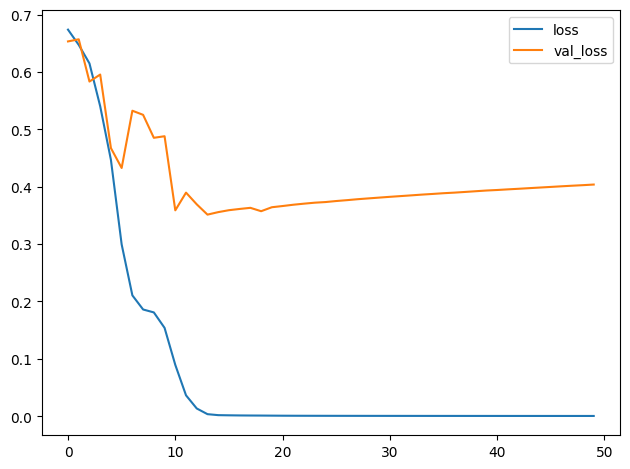

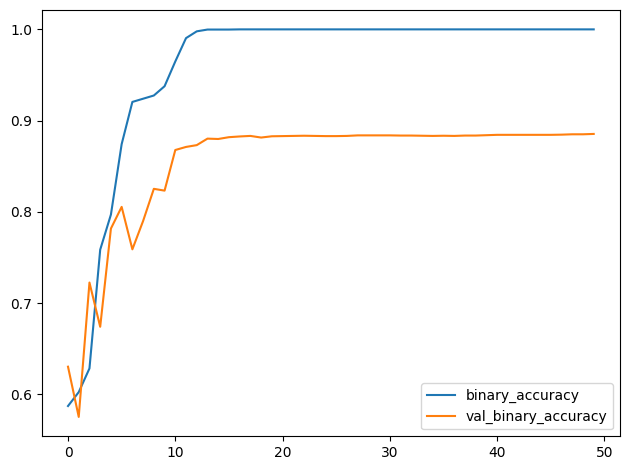

In [8]:
def visualize_model_performance(history, loss_cols = ['loss', 'val_loss'], accuracy_cols = ['binary_accuracy', 'val_binary_accuracy'] ):   
    import pandas as pd
    history_frame = pd.DataFrame(history.history)
    history_frame.loc[:, loss_cols].plot()
    history_frame.loc[:, accuracy_cols].plot()

visualize_model_performance(history)

# 3) Remarks from training #

The learning curves for the model from the tutorial diverged fairly rapidly. This would indicate that it was prone to overfitting and in need of some regularization. The additional layer in our new model would make it even more prone to overfitting. However, adding some regularization with the Dropout layer helped prevent this. These changes improved the validation accuracy of the model by several points.

# 4) Image augmentation #


### Explore some image augmentation transaformations

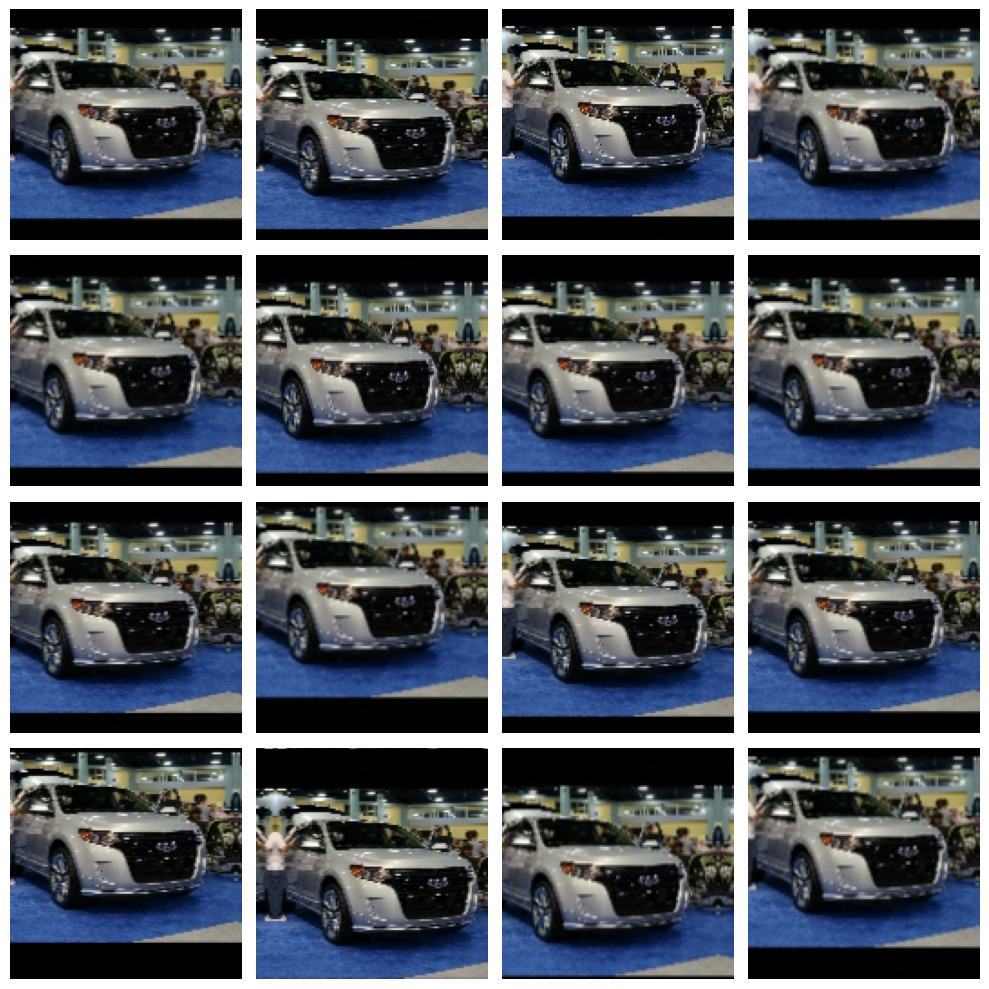

In [12]:
# all of the "factor" parameters indicate a percent-change
augment = keras.Sequential([
    # preprocessing.RandomContrast(factor=0.5),
    #preprocessing.RandomFlip(mode='horizontal'), # meaning, left-to-right
     #preprocessing.RandomFlip(mode='vertical'), # meaning, top-to-bottom
    #preprocessing.RandomWidth(factor=0.15), # horizontal stretch
    # preprocessing.RandomRotation(factor=0.20),
    preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
])


ex = next(iter(ds_train.unbatch().map(lambda x, y: x).batch(1)))

plt.figure(figsize=(10,10))
for i in range(16):
    image = augment(ex, training=True)
    plt.subplot(4, 4, i+1)
    plt.imshow(tf.squeeze(image))
    plt.axis('off')
plt.show()

In [26]:
augmentation_names = ['RandomFlipHorizontal','RandomRotation']

augmentation_configs = {
    'RandomContrast': preprocessing.RandomContrast(factor=0.15),
    'RandomFlipHorizontal': preprocessing.RandomFlip(mode='horizontal'),
    'RandomRotation': preprocessing.RandomRotation(factor=0.20),
    'RandomTranslation': preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2),
    # Add more configurations as needed
}

# model with image augmentation 
def create_augmented_model(augmentations):
    base_model = base_convnet_model()
    
    augmented_model = keras.Sequential([augmentation_configs[augment] for augment in augmentations])

    augmented_model.add(base_model)
    
    augmented_model.add(layers.BatchNormalization(renorm=True))
    augmented_model.add(layers.Flatten())
    
    augmented_model.add(layers.Dense(8, activation='relu'))
    augmented_model.add(layers.Dense(1, activation='sigmoid'))
    augmented_model.build(input_shape=(None, 128, 128, 3))
    
    print(augmented_model.summary())
    return augmented_model

augmented_model = create_augmented_model(augmentation_names)


Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_8 (RandomFlip)  (None, 128, 128, 3)       0         
                                                                 
 random_rotation_8 (RandomRo  (None, 128, 128, 3)      0         
 tation)                                                         
                                                                 
 sequential_18 (Sequential)  (None, 16, 16, 256)       962261    
                                                                 
 batch_normalization_33 (Bat  (None, 16, 16, 256)      1792      
 chNormalization)                                                
                                                                 
 flatten_6 (Flatten)         (None, 65536)             0         
                                                                 
 dense_16 (Dense)            (None, 8)               

In [27]:
aug_model = compile_convnet_model(augmented_model)

In [28]:
history = train_convnet_model(aug_model, ds_train, ds_valid)

Epoch 1/50
80/80 [==============================] - 12s 97ms/step - loss: 0.6752 - binary_accuracy: 0.5759 - val_loss: 0.6468 - val_binary_accuracy: 0.5943
Epoch 2/50
80/80 [==============================] - 7s 93ms/step - loss: 0.6740 - binary_accuracy: 0.5820 - val_loss: 0.6823 - val_binary_accuracy: 0.5789
Epoch 3/50
80/80 [==============================] - 7s 93ms/step - loss: 0.6899 - binary_accuracy: 0.5783 - val_loss: 0.6878 - val_binary_accuracy: 0.5783
Epoch 4/50
80/80 [==============================] - 7s 94ms/step - loss: 0.6923 - binary_accuracy: 0.5871 - val_loss: 0.6850 - val_binary_accuracy: 0.5813
Epoch 5/50
80/80 [==============================] - 8s 95ms/step - loss: 0.6838 - binary_accuracy: 0.5833 - val_loss: 0.6840 - val_binary_accuracy: 0.5801
Epoch 6/50
80/80 [==============================] - 7s 93ms/step - loss: 0.6877 - binary_accuracy: 0.5921 - val_loss: 0.6716 - val_binary_accuracy: 0.6351
Epoch 7/50
80/80 [==============================] - 7s 93ms/step - lo

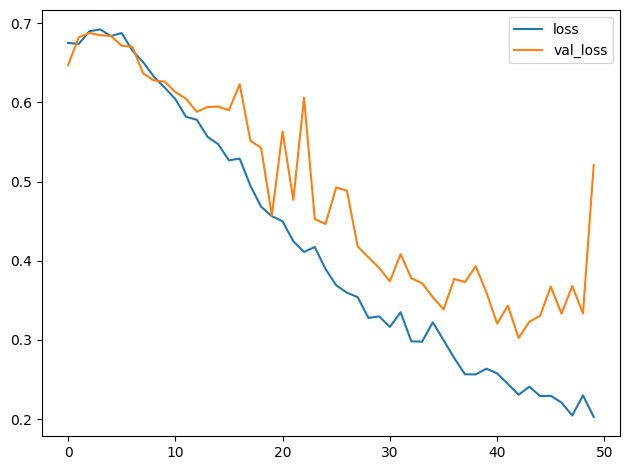

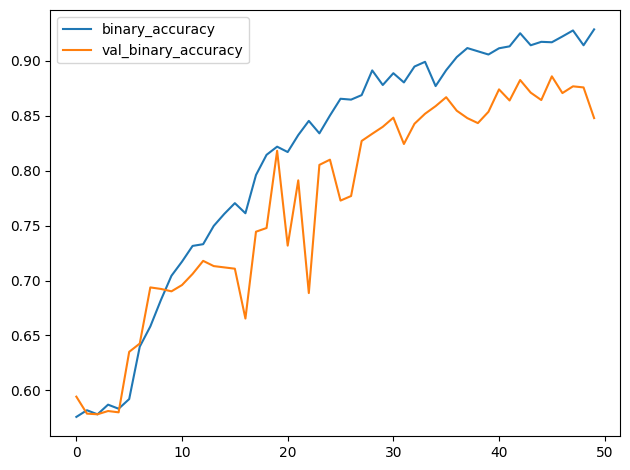

In [29]:
visualize_model_performance(history)

# Remarks #

After applying some augmentations, the model has achieved better generalization. Validation loss and accuracy no more hugely deviates from train loss and accuracy . There are a myriad of options that can be explored like 
#### hyperparameter tuning and adding some dropouts

# Saving the model#

In [33]:
aug_model.save('/kaggle/working/car_truck_cnn_classifier')